In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from simulation.utils import process_to_log_returns_interday, process_to_log_returns
from simulation.SimHestonQE import Heston_QE
from code_from_haozhe.RealizedMomentsEstimator_Aggregate_update import rMoments_mvsek, RM_CL, RM_NP, RM_ORS, RM_ACJV, RM_NP_return
from expansion_methods.all_methods import scipy_mvsek_to_cumulants, gram_charlier_expansion, edgeworth_expansion, saddlepoint_approximation
from code_from_haozhe.GramCharlier_expansion import Expansion_GramCharlier as gram_charlier_expansion_haozhe
from heston_model_properties.theoretical_density import compute_density_via_ifft_accurate

from code_from_haozhe.GramCharlier_expansion import Expansion_GramCharlier
from code_from_haozhe.HestonDensity_FFT import HestonChfDensity_FFT_Gatheral

np.random.seed(0)

In [2]:
time_points = 60 * 22 * 12
start_date = '2014-07-01'
end_date = '2076-07-01'
T = 60
S0 = 100
paths = 1
v0 = 0.19
kappa = 3
theta = 0.19
sigma = 0.4
mu = 0 # martingale
rho = -0.7
rolling_window = 22

In [3]:
print(f'Feller condition: {2 * kappa * theta > sigma**2}')

# Simulation
process = Heston_QE(S0=S0, v0=v0, kappa=kappa, theta=theta, sigma=sigma, mu=mu, rho=rho, T=T, N=time_points, n_paths=paths)
if mu != 0:
    # de-mean the data
    process = process - mu
# process_df = process_to_log_returns_interday(process, start_date, end_date)
process_df = process_to_log_returns(process, start_date, end_date, time_points)

# Estimate moments
technique = RM_NP_return
mvsek = []
for column in process_df.columns:
    mvsek.append(rMoments_mvsek(process_df[column], method=technique, days_aggregate=rolling_window, m1zero=True, ret_nc_mom=True).to_numpy())
mvsek = np.squeeze(np.array(mvsek))
mvsek = pd.DataFrame(mvsek).T # each column is a path and each row is a moment (mean, variance, 3rd moment, 4th moment, skewness, excess kurtosis)
print(mvsek)
mvsek = mvsek.mean(axis=1) # rowwise means

# modify variance
# rm[1] = rm[1]**2

print(mvsek)

Feller condition: True
      0         1         2          3          4          5          6      \
0 -0.093464 -0.095696 -0.093151  -0.092774  -0.103416  -0.109212  -0.107623   
1  0.020446  0.021672  0.021369   0.020138   0.019775   0.019796   0.020547   
2 -0.005321 -0.005739 -0.007134  -0.007700  -0.008119  -0.008690  -0.008724   
3  0.003224  0.003195  0.003896   0.004221   0.004132   0.004447   0.004458   
4 -1.820027 -1.798768 -2.283917  -2.694306  -2.919545  -3.120120  -2.962256   
5  7.712489  6.802967  8.532411  10.407263  10.566133  11.347423  10.561007   

       7         8         9      ...     13147     13148     13149     13150  \
0  -0.099244 -0.136182 -0.110495  ...  0.112354  0.104088  0.117764  0.114863   
1   0.020025  0.023200  0.023580  ...  0.005377  0.005409  0.005021  0.005034   
2  -0.008919 -0.008919 -0.010260  ...  0.000674  0.001040  0.000994  0.001035   
3   0.004540  0.004532  0.005160  ...  0.000107  0.000182  0.000177  0.000186   
4  -3.147601 -2.52

In [4]:
x_density, density = compute_density_via_ifft_accurate(mu=mu, kappa=kappa, theta=theta, sigma=sigma, rho=rho, t=1/12)

In [5]:
f_x = HestonChfDensity_FFT_Gatheral(mu = 0, kappa = 3, theta = 0.19, sigma = 0.4, rho=-0.7, lambdaj=0, muj=0, vj=0, t = 1/12, v0 = 0.19, conditional=False)

In [6]:
cumulants = scipy_mvsek_to_cumulants(mean=mvsek[0], variance=mvsek[1], skewness=mvsek[4], excess_kurtosis=mvsek[5])
cumulants2 = (mvsek[0], mvsek[1], mvsek[2]*3, mvsek[3])
cumulants_true = (-0.00791667, 0.01601168, -0.00056375, 0.00088632)
cumulants_haozhe = (-0.01401158, 0.01647651, -0.0006112, 0.00093973)

In [7]:
print(cumulants)
print(cumulants2)

(0.0036829811345818115, 0.013828692527015558, 0.0003595231442509949, 0.0007384352924259058)
(0.0036829811345818115, 0.013828692527015558, -0.0006476669492545136, 0.0008552638560680836)


In [12]:

x = np.linspace(-2, 2, 1000)
gc = gram_charlier_expansion(x, *cumulants, fakasawa=True)
gc2 = gram_charlier_expansion(x, *cumulants2, fakasawa=True) # fakasawa=True is needed but only works for HF data!
gc_true = gram_charlier_expansion(x, *cumulants_true, fakasawa=True)
gc_haozhe = gram_charlier_expansion(x, *cumulants_haozhe, fakasawa=True)

haozhe_gc = gram_charlier_expansion_haozhe(cumulants)
haozhe_gc2 = gram_charlier_expansion_haozhe(cumulants2)
haozhe_gc_true = gram_charlier_expansion_haozhe(cumulants_true)
haozhe_gc_haozhe = gram_charlier_expansion_haozhe(cumulants_haozhe)

In [9]:
true_cumulant = np.array([-0.00791667, 0.01601168, -0.00056375, 0.00088632])
f_true_x = Expansion_GramCharlier(true_cumulant)

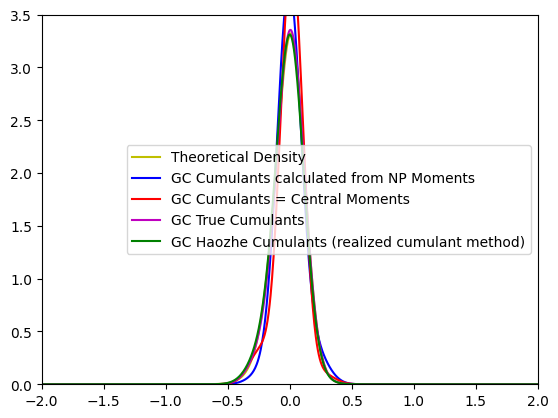

In [13]:
plt.plot(x_density, density, 'y-', label='Theoretical Density')
# plt.plot(x, f_x, label=r'$f(x)$', linestyle='-.', color='blue', linewidth=2)
# plt.plot(x, f_true_x, label=r'$\tilde{f}(x) using\ true\ cumulants$', linestyle='-', color='red', linewidth=2)

plt.plot(x, gc, 'b-', label='GC Cumulants calculated from NP Moments')
plt.plot(x, gc2, 'r-', label='GC Cumulants = Central Moments')
plt.plot(x, gc_true, 'm-', label='GC True Cumulants')
plt.plot(x, gc_haozhe, 'g-', label='GC Haozhe Cumulants (realized cumulant method)')

# plt.plot(x, haozhe_gc, 'b--', label='HaozheGC Cumulants calculated from NP Moments')
# plt.plot(x, haozhe_gc2, 'r--', label='HaozheGC Cumulants = Central Moments')
# plt.plot(x, haozhe_gc_true, 'm--', label='HaozheGC True Cumulants')
# plt.plot(x, haozhe_gc_haozhe, 'g--', label='HaozheGC Haozhe Cumulants (realized cumulant method)')

plt.legend()

# plt.tight_layout()
plt.ylim(0, 3.5)
plt.xlim(-2, 2)
plt.show()